# Alexander Jannaeus vs John Hyrcanus
## Data Loading

In [4]:
import os
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.backend import learning_phase

In [5]:
from PIL import UnidentifiedImageError

# Load images
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            try:
                img = Image.open(img_path)
                images.append(img)
            except UnidentifiedImageError:
                print(f"Skipped non-image file: {filename}")
    return images

In [6]:
# Paths and Loading
path_alex = 'alexander/GoodQuality'
path_john = 'john/GoodQuality'
images_alex = load_images_from_folder(path_alex)
images_john = load_images_from_folder(path_john)

In [7]:
# Count the images for each king
num_images_alex = len(images_alex)
num_images_john = len(images_john)

print(f"Number of images for Alexander: {num_images_alex}")
print(f"Number of images for John: {num_images_john}")

Number of images for Alexander: 74
Number of images for John: 68


In [8]:
def equalize_arrays(arr1, arr2):
    # Determine which array is longer
    if len(arr1) > len(arr2):
        # Shorten arr1 to match the length of arr2
        arr1 = arr1[:len(arr2)]
    elif len(arr2) > len(arr1):
        # Shorten arr2 to match the length of arr1
        arr2 = arr2[:len(arr1)]
    return arr1, arr2

In [9]:
# images_alex, images_john = equalize_arrays(images_alex, images_john)

In [10]:
# Count the images for each king
num_images_alex = len(images_alex)
num_images_john = len(images_john)

print(f"Number of images for Alexander: {num_images_alex}")
print(f"Number of images for John: {num_images_john}")

Number of images for Alexander: 74
Number of images for John: 68


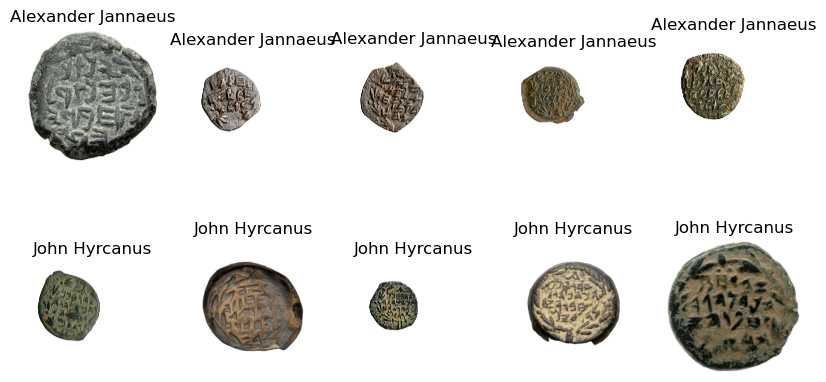

In [11]:
# Display a few samples
plt.figure(figsize=(10, 5))
for i, img in enumerate(images_alex[:5]):
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title("Alexander Jannaeus")
    plt.axis('off')
for i, img in enumerate(images_john[:5]):
    plt.subplot(2, 5, i+6)
    plt.imshow(img)
    plt.title("John Hyrcanus")
    plt.axis('off')
plt.show()

## Data Preprocessing

In [12]:
def preprocessing_pipeline(image, steps):
    """
    Applies a sequence of preprocessing steps to an image.
    
    Parameters:
        image (numpy array): The input image.
        steps (list of functions): The list of preprocessing functions to apply.
        
    Returns:
        numpy array: The processed image.
    """
    for step in steps:
        image = step(image)
    return image

In [352]:
IMG_SIZE = (244,244)
def crop_to_coin(image):
    """
    Crops the image to the bounding box of the non-transparent region.
    """
    if image.shape[-1] == 4:  # Check for RGBA images
        alpha_channel = image[:, :, 3]  # Extract the alpha channel
        coords = cv2.findNonZero(alpha_channel)  # Find non-transparent pixels
        x, y, w, h = cv2.boundingRect(coords)  # Get the bounding box
        cropped_image = image[y:y+h, x:x+w, :3]  # Crop and keep only RGB channels
        return cropped_image

    else:
        raise ValueError("Image does not have an alpha channel. Ensure images are RGBA.")

def resize_image_with_padding(image, size=IMG_SIZE, color=(0, 0, 0)):
    """
    Resizes the image to fit within a square of the given size while preserving the aspect ratio.
    Pads the image with the specified color to match the desired dimensions.

    Args:
        image: The input image (numpy array).
        size: Tuple (width, height) representing the target size.
        color: Padding color, default is black (0, 0, 0) for RGB.
               Use (0, 0, 0, 0) for transparent padding in RGBA images.

    Returns:
        Padded and resized image as a numpy array.
    """
    original_h, original_w = image.shape[:2]
    target_w, target_h = size

    # Calculate scaling factors
    scale_w = target_w / original_w
    scale_h = target_h / original_h
    scale = min(scale_w, scale_h)

    # Calculate the new dimensions while preserving the aspect ratio
    new_w = int(original_w * scale)
    new_h = int(original_h * scale)

    # Resize the image
    resized_image = cv2.resize(image, (new_w, new_h))

    # Create a new blank image with the target size
    if len(image.shape) == 3 and image.shape[2] == 4:  # RGBA
        padded_image = np.zeros((target_h, target_w, 4), dtype=np.uint8)
        padded_image[:, :, 3] = 255  # Set alpha channel to fully opaque
    else:  # RGB
        padded_image = np.full((target_h, target_w, 3), color, dtype=np.uint8)

    # Place the resized image in the center of the padded image
    x_offset = (target_w - new_w) // 2
    y_offset = (target_h - new_h) // 2
    padded_image[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_image

    return padded_image

def normalize_image(image):
    """
    Normalizes the image to the range [0, 1].
    """
    return image / 255.0

def convert_to_grayscale(image):
    """
    Converts the image to grayscale and expands it to 3 channels.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return cv2.merge([gray, gray, gray])    

In [353]:
# ### Code where we test different pre-processing techniques, adding up to relatively strict contours.
# 
# # Convert Pillow image (RGBA) to NumPy array
# image_rgba = np.array(images_alex[184])
# 
# # Extract Alpha Channel (if needed)
# alpha_channel = image_rgba[:, :, 3]  # Transparency information
# 
# # Convert RGBA to BGR for OpenCV processing
# image_bgr = cv2.cvtColor(image_rgba, cv2.COLOR_RGBA2BGR)
# 
# # Step 1: Convert to grayscale
# gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
# 
# # Step 2: Denoising
# blurred = cv2.GaussianBlur(gray, (3, 3), 0)
# 
# # Step 3: Contrast Enhancement
# clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
# enhanced = clahe.apply(blurred)
# 
# # Step 4: Edge Detection
# edges = cv2.Canny(enhanced, 200, 300)
# 
# # Step 5: Morphological Operations
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
# dilated = cv2.dilate(edges, kernel, iterations=3)
# eroded = cv2.erode(dilated, kernel, iterations=2)
# 
# # Step 6: Contour Detection
# contours, hierarchy = cv2.findContours(
#     eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
# )
# 
# # Step 7: Visualization
# contour_image = image_bgr.copy()
# cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
# contoured_image = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)
# # Matplotlib plotting
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# axes = axes.ravel()  # Flatten the 2x3 grid into a 1D array for easier indexing
# 
# # Define titles and images for display
# titles = [
#     "Original Image (BGR)",
#     "Gray Image",
#     "Enhanced Contrast (CLAHE)",
#     "Edges (Canny)",
#     "Dilated and Eroded",
#     "Contours",
# ]
# images = [
#     cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB),  # Convert BGR to RGB for matplotlib
#     gray,
#     enhanced,
#     edges,
#     eroded,
#     cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB),  # Convert BGR to RGB for matplotlib
# ]
# 
# # Loop through each subplot
# for i in range(len(images)):
#     if len(images[i].shape) == 2:  # Grayscale images
#         axes[i].imshow(images[i], cmap="gray")
#     else:  # Color images
#         axes[i].imshow(images[i])
#     axes[i].set_title(titles[i])
#     axes[i].axis("off")
# 
# plt.tight_layout()
# plt.show()

In [1]:
def preprocess_image_for_text(image):
    """
    Preprocesses the image by converting it to grayscale, enhancing contrast,
    and applying adaptive thresholding to binarize the image.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Enhance contrast using histogram equalization
    enhanced = cv2.equalizeHist(gray)

    # Apply adaptive thresholding to highlight text
    binary = cv2.adaptiveThreshold(
        enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
    )

    # Morphological operation: Dilation to enhance text visibility
    kernel = np.ones((2, 2), np.uint8)
    dilated = cv2.dilate(binary, kernel, iterations=1)

    # Optionally, apply erosion after dilation (morphological closing) to clean up
    eroded = cv2.erode(dilated, kernel, iterations=1)

    return cv2.merge([binary, binary, binary])

In [2]:
def apply_edge_detection(image):
    """
    Applies Canny edge detection to highlight edges.
    """
    # Convert to grayscale for edge detection
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply GaussianBlur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply Canny edge detection
    edges = cv2.Canny(blurred, threshold1=50, threshold2=150)
    # Merge back to 3 channels (if needed for the pipeline)
    return cv2.merge([edges, edges, edges])


def enhance_contrast(image):
    """
    Enhances contrast using histogram equalization.
    """
    if image.shape[-1] == 3:  # RGB
        yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        yuv[:, :, 0] = cv2.equalizeHist(yuv[:, :, 0])  # Apply to the Y channel (brightness)
        return cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)
    else:
        raise ValueError("Contrast enhancement requires RGB images.")


def enhance_contrast_clahe(image):
    """
    Enhances contrast using CLAHE.
    """
    if image.shape[-1] == 3:  # RGB
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        lab[:, :, 0] = clahe.apply(lab[:, :, 0])  # Apply to the L channel (lightness)
        return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    else:
        raise ValueError("CLAHE requires RGB images.")

In [3]:
# Define the active preprocessing steps
preprocessing_steps = [
    crop_to_coin,
    resize_image_with_padding,
    preprocess_image_for_text,
    normalize_image
]

# Example: Process a single image
def process_images_with_pipeline(image_list, steps):
    """
    Processes a list of images using the specified pipeline steps.
    """
    processed_images = []
    for img in image_list:
        img_array = np.array(img.convert("RGBA"))  # Ensure RGBA format
        try:
            processed_img = preprocessing_pipeline(img_array, steps)
            processed_images.append(processed_img)
        except ValueError as e:
            print(f"Skipping image due to error: {e}")
    return np.array(processed_images)

# Preprocess datasets
print("Processing Alexander images...")
images_alex_processed = process_images_with_pipeline(images_alex, preprocessing_steps)

print("Processing John images...")
images_john_processed = process_images_with_pipeline(images_john, preprocessing_steps)


NameError: name 'crop_to_coin' is not defined

In [357]:
# Create labels and combine data
labels_alex = np.zeros(len(images_alex_processed))
labels_john = np.ones(len(images_john_processed))
X = np.concatenate((images_alex_processed, images_john_processed), axis=0)
y = np.concatenate((labels_alex, labels_john), axis=0)

In [358]:
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [359]:
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (113, 244, 244, 3)
Testing data shape: (29, 244, 244, 3)
Training labels shape: (113,)
Testing labels shape: (29,)


In [360]:
# # Reshape X_train and X_test to add a single channel dimension for grayscale
# X_train = X_train.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)
# X_test = X_test.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)
# 
# # Verify shapes
# print(f"Training data shape after reshaping: {X_train.shape}")
# print(f"Testing data shape after reshaping: {X_test.shape}")

In [361]:
datagen = ImageDataGenerator(
    rotation_range=180,  
    width_shift_range=0.1,  
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

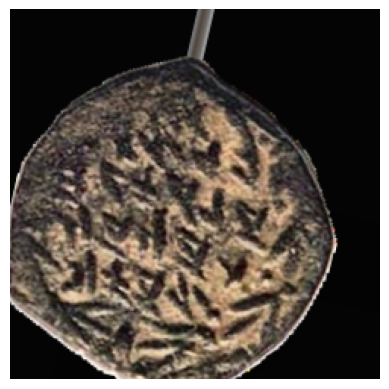

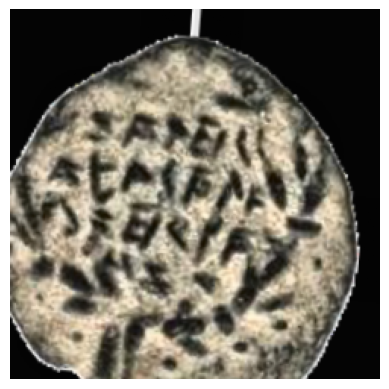

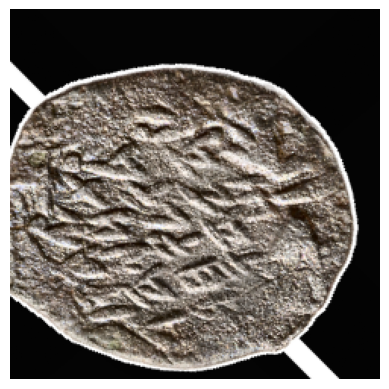

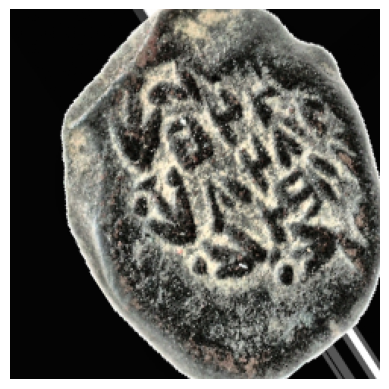

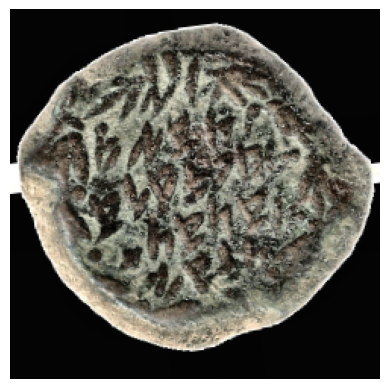

In [362]:
# Display augmented images
augmented_images = datagen.flow(X_train, y_train, batch_size=5)
for i in range(5):
    img = augmented_images[0][0][i]
    plt.imshow(img)
    plt.axis("off")
    plt.show()

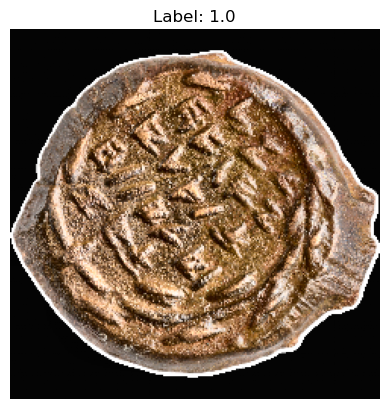

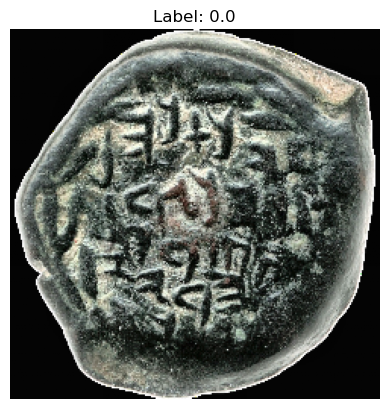

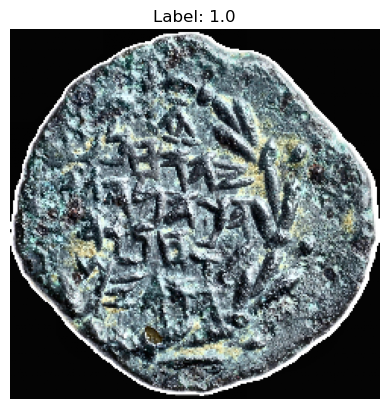

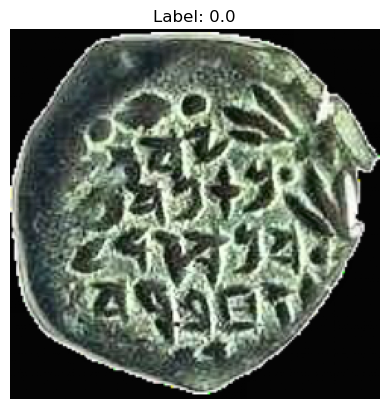

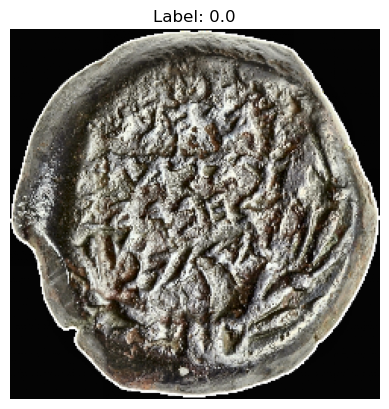

In [363]:
# Display a few training samples with labels
for i in range(5):
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
    plt.show()

# Models Building

In [364]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

In [365]:
epochs = 15
batch_size = 16
learning_rate = 0.001;

### MobileNetV3

In [366]:
from tensorflow.keras.applications import MobileNetV3Large  # or MobileNetV3Small

# Define base model with MobileNetV3
base_model = MobileNetV3Large(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling to reduce feature dimensions
x = Dense(64, activation='relu')(x)  # Dense layer for additional learning
x = Dropout(0.3)(x)  # Dropout to prevent overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Final model
modelMNV3 = Model(inputs=base_model.input, outputs=predictions)

In [367]:
# Compile the model
modelMNV3.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [368]:
# Train the model
# historyMNV3 = modelMNV3.fit(X_train, y_train, batch_size=batch_size,
#                             epochs=epochs, validation_data=(X_test, y_test),
#                             callbacks=[early_stopping])
historyMNV3 = modelMNV3.fit(datagen.flow(X_train, y_train, batch_size=batch_size),  # with image augmentation
                            epochs=epochs, validation_data=(X_test, y_test),
                            callbacks=[early_stopping])


# Evaluate the model on test data
test_loss_MNV3, test_accuracy_MNV3 = modelMNV3.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy_MNV3:.2f}")

Epoch 1/15


2024-11-20 14:07:52.958480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 3s 196ms/step - loss: 0.7494 - accuracy: 0.4425 - val_loss: 0.6851 - val_accuracy: 0.5862
Epoch 2/15
8/8 [==============================] - 1s 149ms/step - loss: 0.6978 - accuracy: 0.5221 - val_loss: 0.7558 - val_accuracy: 0.4138
Epoch 3/15
8/8 [==============================] - 1s 154ms/step - loss: 0.7624 - accuracy: 0.5044 - val_loss: 0.7426 - val_accuracy: 0.4138
Epoch 4/15
8/8 [==============================] - 1s 131ms/step - loss: 0.7175 - accuracy: 0.5133 - val_loss: 0.6740 - val_accuracy: 0.5862
Epoch 5/15
8/8 [==============================] - 1s 138ms/step - loss: 0.7223 - accuracy: 0.4867 - val_loss: 0.6764 - val_accuracy: 0.5862
Epoch 6/15
8/8 [==============================] - 1s 137ms/step - loss: 0.6938 - accuracy: 0.4690 - val_loss: 0.7009 - val_accuracy: 0.4483
Epoch 7/15
8/8 [==============================] - 1s 132ms/step - loss: 0.6942 - accuracy: 0.5133 - val_loss: 0.6922 - val_accuracy: 0.4138
Epoch 8/15
8/8 [===============

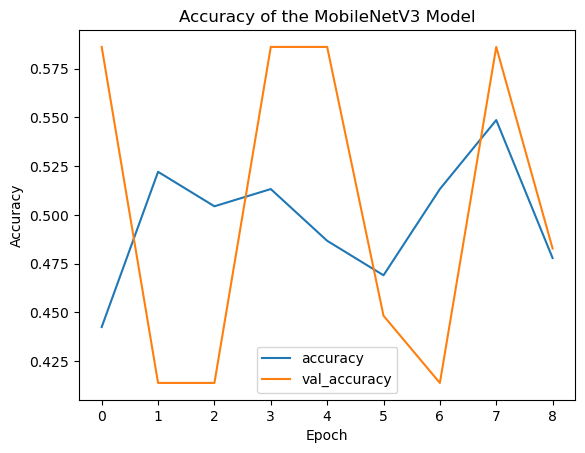

In [369]:
# Plot accuracy
plt.plot(historyMNV3.history['accuracy'], label='accuracy')  # Train accuracy
plt.plot(historyMNV3.history['val_accuracy'], label='val_accuracy')  # Validation accuracy
plt.title('Accuracy of the MobileNetV3 Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### VGG16

In [370]:
from tensorflow.keras.applications import VGG16
# VGG16 model with pre-trained weights
base_model = VGG16(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), include_top=False, weights='imagenet')
# Freeze the base model's layers to retain pre-trained weights
base_model.trainable = False

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling to reduce feature dimensions
x = Dense(64, activation='relu')(x)  # Dense layer for additional learning
x = Dropout(0.3)(x)  # Dropout to prevent overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Final model
modelVGG16 = Model(inputs=base_model.input, outputs=predictions)


In [371]:
# Compile model
modelVGG16.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [372]:
# Train the model
# historyVGG16 = modelVGG16.fit(X_train, y_train, batch_size=batch_size,
#                     epochs=epochs, validation_data=(X_test, y_test), callbacks=[early_stopping])
historyVGG16 = modelVGG16.fit(datagen.flow(X_train, y_train, batch_size=batch_size), 
                              epochs=epochs, validation_data=(X_test, y_test), callbacks=[early_stopping])
# Evaluate the model on test data
test_loss_VGG16, test_accuracy_VGG16 = modelVGG16.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy_VGG16:.2f}")

Epoch 1/15


2024-11-20 14:08:06.402858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 11s 1s/step - loss: 0.7701 - accuracy: 0.5398 - val_loss: 0.6939 - val_accuracy: 0.5862
Epoch 2/15
8/8 [==============================] - 11s 1s/step - loss: 0.7293 - accuracy: 0.5133 - val_loss: 0.6899 - val_accuracy: 0.5862
Epoch 3/15
8/8 [==============================] - 10s 1s/step - loss: 0.6874 - accuracy: 0.6018 - val_loss: 0.6883 - val_accuracy: 0.5862
Epoch 4/15
8/8 [==============================] - 11s 1s/step - loss: 0.6916 - accuracy: 0.5310 - val_loss: 0.6888 - val_accuracy: 0.5862
Epoch 5/15
8/8 [==============================] - 11s 1s/step - loss: 0.7056 - accuracy: 0.5575 - val_loss: 0.6899 - val_accuracy: 0.6207
Epoch 6/15
8/8 [==============================] - 12s 2s/step - loss: 0.6825 - accuracy: 0.5664 - val_loss: 0.6909 - val_accuracy: 0.6897
Epoch 7/15
8/8 [==============================] - 11s 1s/step - loss: 0.7007 - accuracy: 0.5310 - val_loss: 0.6907 - val_accuracy: 0.6207
Epoch 8/15
1/1 [=============================

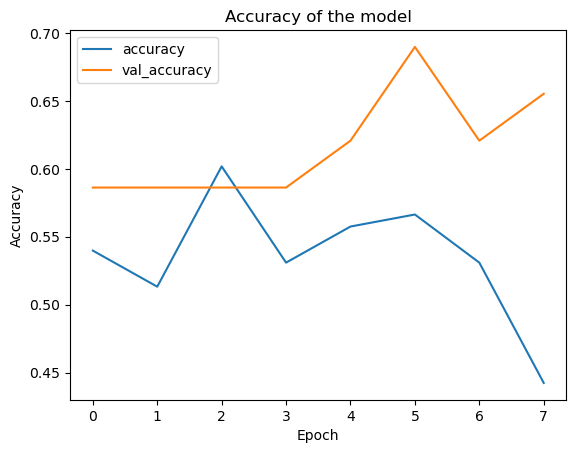

In [373]:
plt.plot(historyVGG16.history['accuracy'], label='accuracy') # Plot the accuracy of the model on the train data
plt.plot(historyVGG16.history['val_accuracy'], label = 'val_accuracy') # Plot the accuracy of the model on the validation data
plt.title('Accuracy of the model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Custom CNN

In [374]:
# Define model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE[0],IMG_SIZE[1], 3)), # 1 for grayscale and 3 for RGB
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [375]:
# Compile model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [376]:
# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [377]:
# Train the model
# historyCNN = model.fit(X_train, y_train, batch_size=batch_size,
#                     epochs=epochs, validation_data=(X_test, y_test), callbacks=[early_stopping])
historyCNN = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                       epochs=epochs, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on test data
test_loss_CNN, test_accuracy_CNN = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy_CNN:.2f}")

Epoch 1/15


2024-11-20 14:09:35.913573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 1s 117ms/step - loss: 2.3989 - accuracy: 0.5310 - val_loss: 1.3207 - val_accuracy: 0.4138
Epoch 2/15
8/8 [==============================] - 1s 111ms/step - loss: 0.9758 - accuracy: 0.5044 - val_loss: 0.6837 - val_accuracy: 0.6552
Epoch 3/15
8/8 [==============================] - 1s 109ms/step - loss: 0.7043 - accuracy: 0.5398 - val_loss: 0.6749 - val_accuracy: 0.5862
Epoch 4/15
8/8 [==============================] - 1s 103ms/step - loss: 0.6922 - accuracy: 0.5310 - val_loss: 0.6751 - val_accuracy: 0.5862
Epoch 5/15
8/8 [==============================] - 1s 121ms/step - loss: 0.6888 - accuracy: 0.4867 - val_loss: 0.6790 - val_accuracy: 0.5862
Epoch 6/15
8/8 [==============================] - 1s 109ms/step - loss: 0.6965 - accuracy: 0.4336 - val_loss: 0.6807 - val_accuracy: 0.5862
Epoch 7/15
8/8 [==============================] - 1s 112ms/step - loss: 0.6900 - accuracy: 0.5044 - val_loss: 0.6833 - val_accuracy: 0.5862
Epoch 8/15
1/1 [===============

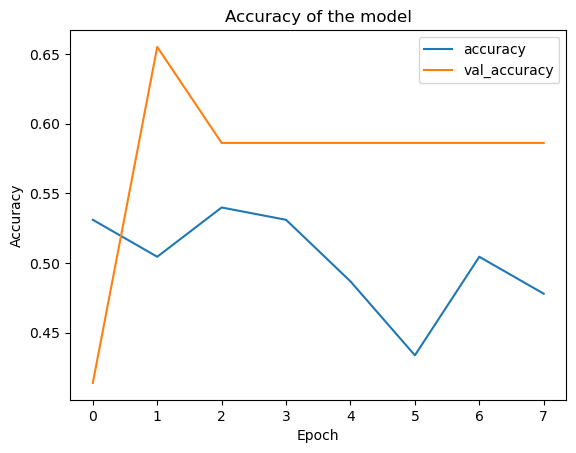

In [378]:
plt.plot(historyCNN.history['accuracy'], label='accuracy') # Plot the accuracy of the model on the train data
plt.plot(historyCNN.history['val_accuracy'], label = 'val_accuracy') # Plot the accuracy of the model on the validation data
plt.title('Accuracy of the model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

         Model Test Accuracy Test Loss
0  MobileNetV3          0.59    0.6740
1        VGG16          0.59    0.6883
2   Custom CNN          0.59    0.6749


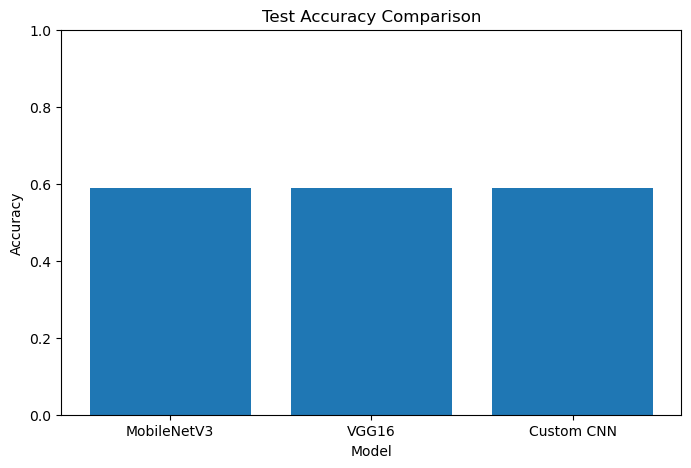

In [379]:
### Final Results Summary

# Collect results from the three models
results_summary = {
    "Model": ["MobileNetV3","VGG16", "Custom CNN"],
    "Test Accuracy": [
        f"{test_accuracy_MNV3:.2f}",  # MobileNetV2 test accuracy
        f"{test_accuracy_VGG16:.2f}",  # VGG16 test accuracy
        f"{test_accuracy_CNN:.2f}"  # Custom CNN test accuracy
    ],
    "Test Loss": [
        f"{test_loss_MNV3:.4f}",  # MobileNetV2 test loss
        f"{test_loss_VGG16:.4f}",  # VGG16 test loss
        f"{test_loss_CNN:.4f}"  # Custom CNN test loss
    ]
}

# Display results in a clear format
import pandas as pd

results_df = pd.DataFrame(results_summary)
print(results_df)

# Optional: Save the results to a CSV for later comparison
results_df.to_csv("model_results_summary.csv", index=False)

# Display bar chart for visual comparison
plt.figure(figsize=(8, 5))
plt.bar(results_summary["Model"], [float(acc) for acc in results_summary["Test Accuracy"]])
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.title("Test Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()